# Handout #5: Unsupervised Learning (optimization-based clustering)

## Problem 7

### Definition of the crisp clustering function

In [22]:
import numpy as np
import random


def proximity_sense():
    # if the proximity function is a 
    # - dissimilarity metric (DM), must return the minimum function
    # - simillarity metric (SM), must return the maximum function
    
    # we are working with a distance, 
    # so a dissimilarity metric must be assumed and 
    # return the min() function
    
    return min


def get_best_cost_value(vector: np.ndarray) -> float:
    # returns the best cost value from 'cost_list'
    
    # will get the minimum or maximum value
    #
    sense_func = proximity_sense()
    best_cost_value = sense_func(vector)
    
    return best_cost_value


def get_best_cost_index_from(vector: np.ndarray) -> int:
    # returns the position (zero indexed) of 
    # the minimum value or maximum value
    # that cotains 'values_list'
    
    best_position = vector.index(get_best_cost_value(vector))
    
    return best_position
    
    
def get_initial_thetas(X: np.ndarray, M: int) -> np.ndarray:
    # returns a random matrix of cluster definitions
    
    # test if we have sufficient datapoints
    #
    n_datapoints = len(X)
    
    if n_datapoints < M:
        raise ValueError("Insufficient number of datapoints")
    
    
    # as we can define the cluster by its radius, 
    # the matrix shape is M x 1
    # where M is the number of desired clusters
    #
    # to select the cluster's radius, 
    # will select M random datapoints and use 
    # its radius as the cluster one
    # 
    # we think its a very fast initialization method, 
    # but the drawback is that is not assured that
    # the M selected values have an uniform distribution
    # over the radius value space
    # we also verify that there aren't repeated values
    #
    radius_list = list()
    
    for i in range(M):
        rand_index = random.randint(a=0, b=n_datapoints - 1)
        radius = np.linalg.norm(X[rand_index])
        while radius in radius_list:
            rand_index = random.randint(a=0, b=n_datapoints - 1)
            radius = np.linalg.norm(X[rand_index])
        radius_list.append([radius])
    
    # sort list to try to get clusters ordered by their radius
    radius_list.sort()
    
    thetas = np.array(radius_list, dtype=float)
    
    return thetas


def proximity_func():
    
    return random.random()


def proximity_partial():
    pass


def calc_membership_at(mode: str, cluster_num: int, vector: np.ndarray) -> float:
    # return membership level of a datapoint to 'cluster_num'
    # according to the proximity values that 'vector' cotains
    #
    
    # select min or max
    #
    sense_func = proximity_sense()
    
    if mode == 'crisp':
        if cluster_num == vector.index(sense_func(vector)):
            level = 1
        else:
            level = 0
    elif mode == 'fuzzy':
        level = 1
    else:
        raise ValueError("only 'crisp' or 'fuzzy' clustering modes supported")
    
    return level


def calc_membership(mode: str, func, X: np.ndarray, thetas: np.ndarray) -> np.ndarray:
    # return crisp membership array
    #
    n_datapoints = len(X)
    n_clusters = len(thetas)
    
    membership = np.empty((n_datapoints, n_clusters), dtype=int)
    
    for i in range(n_datapoints):
        
        proximity_vector = np.empty(n_clusters, dtype=float)
        
        # populate proximity_vector
        #
        for j in range(n_clusters):
            proximity_vector[j] = proximity_func()
        
        # compute membership
        #
        for j in range(n_clusters):
            membership[i, j] = calc_membership_at(
                mode=mode, 
                cluster_num=j, 
                vector=proximity_vector)
    
    return membership
    

def calc_thetas(func, X: np.ndarray, membership: np.ndarray) -> np.ndarray:
    
    return get_initial_thetas(X, 3)  # TODO


def calc_thetas_distance(new_thetas: np.ndarray, old_thetas: np.ndarray) -> float:
    # return the euclidean distance between thetas vectors
    #
    thetas_delta = (new_thetas - old_thetas)
    distance = np.linalg.norm(thetas_delta)
    
    return distance


def calc_cost_value(X: np.ndarray, membership: np.ndarray, thetas: np.ndarray) -> float:
    # return the cost function value
    #
    cost_value = np.random.random(1)
    
    return cost_value


def get_cluster_labels(thetas: np.ndarray) -> np.ndarray:
    pass


def do_crisp_clust(X: np.ndarray, M: int, n_iter: int , n_attempts: int, eps: float) -> list:
    # X: datapoints to classify
    # M: number of desired clusters
    # n_iter: maximum number of iterations per attempt
    # n_attempts: maximum number of attempts
    # eps: stopping delta value
    #
    # returns the best clusters labels list,
    # the best cluster theta vector and
    # the best cost value history
    # from the best attempt
    
    # CONSTANTS
    #
    LABELS_FIELD = 'cluster_labels'
    THETAS_FIELD = 'theta_vector'
    COST_HIST_FIELD = 'cost_history'
    BEST_COST_FIELD = 'best_cost'
    
    # VARIABLES
    #
    
    # an empty list to store each attempt
    #
    attempt_list = list()
    
    for attempt in range(n_attempts):
        
        # theta values initialization
        #
        thetas = get_initial_thetas(X=X, M=M)
        
        # cost function value history vector
        #
        cost_value_history = np.empty(0, dtype=float)
        
        # delta criteria finalization
        #
        delta = eps

        # iterations counter
        #
        it = 0

        # will iterate until n_iterations are exhausted or 
        # cost function value variation is above epsilon value
        #
        while it < n_iter and delta >= eps:
            
            # calc membership matrix
            #
            membership = calc_membership(
                mode='crisp',
                func=proximity_func, 
                X=X, 
                thetas=thetas)
            
            # calculate next clusters centroids
            #
            old_thetas = thetas
            thetas = calc_thetas(
                func=proximity_partial, 
                X=X, 
                membership=membership)
            
            # calculate thetas delta
            #
            delta = calc_thetas_distance(
                new_thetas=thetas, 
                old_thetas=old_thetas)
            
            # calculate cost function value
            #
            cost_value = calc_cost_value(
                X=X, 
                membership=membership, 
                thetas=thetas)
            
            cost_value_history = np.append(
                cost_value_history, cost_value)
            
            # go to next try
            #
            it += 1
        
        # save results
        #
        best_cost_value = get_best_cost_value(
            vector=cost_value_history)
        
        cluster_labels = get_cluster_labels(thetas=thetas)
        
        new_entry = {
            LABELS_FIELD: cluster_labels,
            THETAS_FIELD: thetas,
            COST_HIST_FIELD: cost_value_history,
            BEST_COST_FIELD: best_cost_value
        }
        
        attempt_list.append(new_entry)
        
    # Select the best attempt
    #
    best_cost_value = None
    for attempt_entry in attempt_list:
        if best_cost_value is None or get_best_cost_index_from([attempt_entry[BEST_COST_FIELD], best_cost_value]) == 0:
            
            best_cluster_labels = attempt_entry[LABELS_FIELD]
            best_theta_vector = attempt_entry[THETAS_FIELD]
            best_cost_value_history = attempt_entry[COST_HIST_FIELD]
            best_cost_value = attempt_entry[BEST_COST_FIELD]
            
    return best_cluster_labels, best_theta_vector, best_cost_value_history

Load needed libraries

In [2]:
import numpy as np

### Load the *dataset*

Our group is '01'

In [3]:
group = '01'  # BERNAT LADARIA, Lluís
ds = 7

Load vectors from file

In [4]:
data = np.loadtxt('ds'+group+str(ds)+'.txt')

Split data and labels

In [5]:
X = data[:, 0:2]
y = data[:, 2]

How many vectors we have to classify?

In [6]:
X.shape

(300, 2)

How many classes?

In [7]:
y_classes = np.unique(y)
y_classes

array([0., 1., 2.])

We have a 3 classes classification problem

### Cluster the data

Import necessary functions and classes

In [8]:
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [9]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as col

Initialization

In [10]:
M = 3
n_iter = 20
n_attempts = 5
eps = 1e-3

Cluster it!

In [23]:
random.seed(42)

[best_cluster_labels, best_theta_vector, cost_value_history] = \
    do_crisp_clust(X=X, M=M, n_iter=n_iter, n_attempts=n_attempts, eps=eps)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

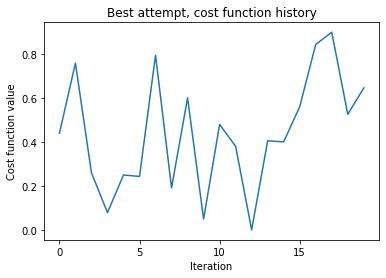

In [12]:
plt.title("Best attempt, cost function history")
plt.xlabel("Iteration")
plt.ylabel("Cost function value")
xticks_list = range(0, n_iter, 5)
plt.xticks(xticks_list)
plt.plot(cost_value_history)